- 1. Colocar Queries em dicionário
Nas linhas abaixo retirou-se a informação de cada paciente e colocou-se em um dicionario. Sendo as keys o código do paciente e  a value a sua situação clinica (query)

In [2]:
import xml.etree.ElementTree as ET
import matplotlib as plt
import pandas as pd
import numpy as np
import trec
import pprint as pp
import pickle

Qrels = "qrels-clinical_trials.txt"
Queries = "topics-2014_2015-summary.topics"


with open(Queries, 'r') as queries_reader:
    txt = queries_reader.read()

root = ET.fromstring(txt)

cases = {}
cases_age = {}
cases_genre = {}
for query in root.iter('TOP'):
    q_num = query.find('NUM').text
    q_title = query.find('TITLE').text
    cases[q_num] = q_title
    #cases_age[q_num] = query.find('AGE').text
    #cases_genre[q_num] = query.find('GENDER').text

eval = trec.TrecEvaluation(cases, Qrels)

pickle.dump(cases, open("cases.bin", "wb"))
#pickle.dump(cases_age, open("cases_age.bin", "wb"))
#pickle.dump(cases_genre, open("cases_genre.bin", "wb"))

for paciente, query in cases.items():
    print(paciente, query)

20141 58-year-old woman with hypertension and obesity presents with exercise-related episodic chest pain radiating to the back.
       		
20142 8-year-old boy with 2 days of loose stools, fever, and cough after returning from a trip to Colorado. Chest x-ray shows bilateral lung infiltrates.
       		
20143  58-year-old female non-smoker with left lung mass on x-ray. Head CT shows a solitary right frontal lobe mass.
       		
20144 2-year-old boy with fever and irritability for 5 days. Physical exam findings include conjunctivitis, strawberry tongue, and desquamation of the fingers and toes. Lab results include low albumin, elevated white blood cell count and C-reactive protein, and urine leukocytes. Echo shows moderate dilation of the coronary arteries.
       		
20145 56-year-old woman presents with shortness of breath 3 weeks after surgical mastectomy. Physical exam is significant for right calf tenderness and decreased breath sounds at the right base. Her D-dimer level is elevated.


- 2. Retirar Informação dos documentos clinicos 

In [3]:
#
import xml.etree.ElementTree as ET
import tarfile

tar = tarfile.open("clinicaltrials.gov-16_dec_2015.tgz", "r:gz")
ids = []
brief_titles = []
detailed_descriptions = []
brief_summaries = []
criterias = []
genders = []
minimum_ages = []
maximum_ages = []

namelist = tar.getnames()

for tarinfo in tar:
    if tarinfo.size > 500:
        txt = tar.extractfile(tarinfo).read().decode("utf-8", "strict")
        root = ET.fromstring(txt)
        judged = False
        id=''
        bt=''
        dt=''
        bs=''
        cs=''
        ge=''
        ma=''
        mi=''

        for doc_id in root.iter('nct_id'):
            if doc_id.text in eval.judged_docs:
                judged = True
                id=doc_id.text.strip()
                break
                
        if judged is False:
            continue

        brief_title = root.find('brief_title').text.strip()
        bt=brief_title

        for dd in root.iter('detailed_description'):
            for child in dd:
                dd=child.text.strip()
        if dd == '':
            dd=brief_title
              
        for bs in root.iter('brief_summary'):
            for child in bs:
                bs=child.text.strip()
        if bs == '':
            bs=brief_title
                
        for c in root.iter('criteria'):
            for child in c:
                cs=child.text.strip()
        if cs=='':
            cs= brief_title

        for gender in root.iter('gender'):
            ge=gender.text.strip()
        if ge=='' or ge=='N/A':
            ge='Both'

        for minimum_age in root.iter('minimum_age'):
            mi=minimum_age.text.strip()
        if mi=='' or mi=='N/A':
            mi='0 years'

        for maximum_age in root.iter('maximum_age'):
            ma=maximum_age.text.strip()
        if ma=='' or ma=='N/A':
            ma='100 years'

       
        if id!='' and bt!='' and dd!='' and bs!='' and cs!='' and ge!='' and mi!='' and ma!='':
            ids.append(id)
            brief_titles.append(bt)
            detailed_descriptions.append(dd)
            brief_summaries.append(bs)
            criterias.append(cs)
            genders.append(ge)
            minimum_ages.append(mi)
            maximum_ages.append(ma)
        else:
            print('failed')
            print(id,bt,dd,bs,cs)
            continue

        if len(ids) != len(brief_titles) or len(detailed_descriptions) != len(brief_summaries) or len(brief_summaries) != len(criterias):
            print("error")
            print(brief_title)
            print(detailed_descriptions[0].text.strip())
            print(brief_summaries[0].text.strip())
            print(criterias[0].text.strip())
            break
tar.close()

pickle.dump(ids, open("ids.bin", "wb"))
pickle.dump(brief_titles, open("brief_title.bin", "wb"))
pickle.dump(detailed_descriptions, open("detailed_description.bin", "wb"))
pickle.dump(brief_summaries, open("brief_summary.bin", "wb"))
pickle.dump(criterias, open("criteria.bin", "wb"))
pickle.dump(genders, open("gender.bin", "wb"))
pickle.dump(minimum_ages, open("minimum_age.bin", "wb"))
pickle.dump(maximum_ages, open("maximum_age.bin", "wb"))


- 3. Modelos para avaliar distancia entre queries e documentos

In [4]:
import abc
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import pairwise_distances
from collections import Counter
from nltk.stem.porter import PorterStemmer
import re

def stemming_tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    words = [PorterStemmer.stem(word) for word in words]
    return words


class RetrievalModel: 
    @abc.abstractmethod  
    def search(self):  
        pass  

class VSM(RetrievalModel):  # subclasse do nosso retrievalmodel - modelo VSM
    def __init__(self,tipo,stopw='english'):
        self.tipo=tipo
        self.stopw=stopw
    def search(self, caseid, docs):  # método search que calcula a distancia entre o querie e os diferentes documentos
        '''este método recebe 2 argumentos (paciente id e docs) de seguida vectoriza os documentos e depois mede a 
        distancia entre o query e os documentos. retorna os scores para cada documento'''
        n=1
        if self.tipo=="unigram":
            pass
        elif self.tipo=="bigram":
            n=2
        else:
            raise ValueError('unigram or bigram')
        index = TfidfVectorizer(ngram_range=(
            1, n), stop_words=self.stopw)
        index.fit(docs)
        X = index.transform(docs)
        query = cases[caseid]
        query_tfidf = index.transform([query])
        doc_scores = 1-pairwise_distances(X, query_tfidf, metric='cosine')
        scores = doc_scores.tolist()
        return scores
    
class LMJM(RetrievalModel): # subclasse do nosso retrievalmodel. modelo LM Jellineck Mercier Smoothing
    def __init__(self,tipo,stopw='english'):
        self.tipo=tipo
        self.stopw=stopw
    def search(self, caseid, docs,lmbd_insert):
        '''Este métod tem como argumentos o case id e os documentos. vectoriza os documentos e de seguida calcula
        as diferentes probabilidades para os queries'''
        n=1
        if self.tipo=="unigram":
            pass
        elif self.tipo=="bigram":
            n=2
        else:
            raise ValueError('unigram or bigram')
        index = CountVectorizer(ngram_range=(1, n), analyzer='word',stop_words=self.stopw)
        corpus_cv = index.fit(docs).transform(docs)
        lmbd = lmbd_insert
        prob_word_docs = corpus_cv/np.sum(corpus_cv, axis=1)
        prob_word_corpus = np.sum(corpus_cv, axis=0)/np.sum(corpus_cv)
        log_mixture = np.log(lmbd*prob_word_docs + (1-lmbd)*prob_word_corpus)
        query = cases[caseid]
        query_cv = index.transform([query])
        total = log_mixture*query_cv.T
        return total.flatten().tolist()

In [5]:
# split into train and test
idx_cases=list(cases.keys())

from sklearn.model_selection import train_test_split

cases_train ,cases_test = train_test_split(idx_cases,test_size=0.2)  

In [6]:
def flatten_arr(l):
    return [item for sublist in l for item in sublist]

def implement_vsm(tipo,stopw):
    avg_precision_11point_tvsm,recall_11point_tvsm,total_relv_ret_tvsm = [],[],[]
    metrics_all_vsm=[]
    p10_tvsm, recall_tvsm, ap_tvsm, ndcg_tvsm, mrr_tvsm=0,0,0,0,0
    for caseid in cases_train:
        # implementar VSM unigram
        scores= flatten_arr(VSM(tipo,stopw).search(caseid,brief_summaries))
        results_vsm = pd.DataFrame(list(zip(ids, scores)), columns = ['_id', 'score'])
        results_ord_vsm = results_vsm.sort_values(by=['score'], ascending = False)
    
        p10vsm, recallvsm, apvsm, ndcg5vsm, mrrvsm = eval.eval(results_ord_vsm, caseid)
        precision_11pointvsm, recall_11pointvsm, total_relv_retvsm = eval.evalPR(results_ord_vsm, caseid)
        p10_tvsm+=p10vsm
        recall_tvsm+=recallvsm
        ap_tvsm+= apvsm
        ndcg_tvsm+=ndcg5vsm
        mrr_tvsm+=mrrvsm
        avg_precision_11point_tvsm.append(precision_11pointvsm)
        recall_11point_tvsm.append(recall_11pointvsm)
        total_relv_ret_tvsm.append(total_relv_retvsm)
        #if (np.shape(recall_11pointvsm) != (0,)):
            #avg_precision_11point_tvsm = avg_precision_11pointvsm + precision_11pointvsm
    metrics_all_vsm.append([p10_tvsm/len(cases_train), recall_tvsm/len(cases_train), ap_tvsm/len(cases_train), ndcg_tvsm/len(cases_train), mrr_tvsm/len(cases_train)])
    return metrics_all_vsm

In [7]:
metrics_all_vsm1=implement_vsm("unigram","english")
print(metrics_all_vsm1)  #unigrama c/stop words

[[0.09999999999999999, 0.9791666666666666, 0.08012636527165994, 0.11831125978138753, 0.0048090182018753445]]


In [8]:
metrics_all_vsm2=implement_vsm("bigram","english")
print(metrics_all_vsm2)  #bigrama c/stop words

[[0.11041666666666668, 0.9791666666666666, 0.07862158589030463, 0.10540574062878272, 0.0048090182018753445]]


In [9]:
metrics_all_vsm3=implement_vsm("unigram",None)
print(metrics_all_vsm3)  #unigrama s/stop words

[[0.09791666666666667, 0.9791666666666666, 0.07621057045934872, 0.10490356563943583, 0.0048090182018753445]]


In [10]:
metrics_all_vsm4=implement_vsm("bigram",None)
print(metrics_all_vsm4)  #unigrama s/stop words

[[0.09166666666666669, 0.9791666666666666, 0.07478405887836546, 0.10882538194419895, 0.0048090182018753445]]


In [31]:
# tune lambda from 0.1 to 1
def implement(tipo,stopwords):
    avg_precision_11point_t,recall_11point_t,total_relv_ret_t = [],[],[]
    metrics_all=[]
    for lmbd in np.arange(0.1,1,0.1):
        p10_t, recall_t, ap_t, ndcg_t, mrr_t=0,0,0,0,0
        for caseid in cases_train:
            # implementar LMJM unigram
            scores_LMJM= LMJM(tipo,stopwords).search(caseid,brief_summaries,lmbd)
            results_LMJM = pd.DataFrame(list(zip(ids, scores_LMJM[0])), columns = ['_id', 'score_lmj'])
            results_ord_LMJM = results_LMJM.sort_values(by=['score_lmj'], ascending = False)
            #all_scores_LMJM.append(sorted(list(zip(ids,scores_LMJM[0])),key=lambda x:x[1],reverse=True))
            p10, recall, ap, ndcg5, mrr = eval.eval(results_ord_LMJM, caseid)
            precision_11point, recall_11point, total_relv_ret = eval.evalPR(results_ord_LMJM, caseid)
            p10_t+=p10
            recall_t+=recall
            ap_t+= ap
            ndcg_t+=ndcg5
            mrr_t+=mrr
            avg_precision_11point_t.append(precision_11point)
            recall_11point_t.append(recall_11point)
            total_relv_ret_t.append(total_relv_ret)
            #if (np.shape(recall_11point) != (0,)):
                #avg_precision_11point_t = avg_precision_11point + precision_11point
        metrics_all.append([p10_t/len(cases_train), recall_t/len(cases_train), ap_t/len(cases_train), ndcg_t/len(cases_train), mrr_t/len(cases_train)])
    return metrics_all

In [32]:
metrics_lmjm=implement("unigram","english")
print(metrics_lmjm) #LMJM unigram c/stopwords


[[0.11041666666666665, 0.9791666666666666, 0.07217623250350609, 0.08748474317698363, 0.0048090182018753445], [0.11458333333333333, 0.9791666666666666, 0.07439020130785313, 0.09318527775595824, 0.0048090182018753445], [0.1145833333333333, 0.9791666666666666, 0.07505250602425932, 0.0977459069778569, 0.0048090182018753445], [0.11874999999999997, 0.9791666666666666, 0.07553538295027551, 0.09344905304280038, 0.0048090182018753445], [0.11666666666666663, 0.9791666666666666, 0.07369286917804478, 0.09221984266237755, 0.0048090182018753445], [0.1145833333333333, 0.9791666666666666, 0.07365471432663946, 0.09391460156330829, 0.0048090182018753445], [0.1145833333333333, 0.9791666666666666, 0.07188857705390668, 0.09229763338096371, 0.0048090182018753445], [0.10833333333333332, 0.9791666666666666, 0.07140181819270762, 0.09270147126942008, 0.0048090182018753445], [0.09999999999999999, 0.9791666666666666, 0.07253542832121508, 0.09144710255218842, 0.0048090182018753445]]


In [34]:
metrics_lmjm1=implement("unigram",None)
print(metrics_lmjm1)  #LMJM unigram s/stopwords

[[0.09791666666666667, 0.9791666666666666, 0.07210252088743462, 0.09106713838398332, 0.0048090182018753445], [0.11041666666666665, 0.9791666666666666, 0.07425510245341439, 0.09469919465999536, 0.0048090182018753445], [0.10833333333333332, 0.9791666666666666, 0.0761460469746568, 0.09578362245831851, 0.0048090182018753445], [0.11041666666666665, 0.9791666666666666, 0.07448183844242325, 0.09294313495211681, 0.0048090182018753445], [0.10833333333333332, 0.9791666666666666, 0.0722312328782538, 0.09242460417258154, 0.0048090182018753445], [0.10416666666666667, 0.9791666666666666, 0.07236357408379691, 0.0928833268915173, 0.0048090182018753445], [0.09999999999999999, 0.9791666666666666, 0.0698108350036196, 0.08800457259359845, 0.0048090182018753445], [0.09791666666666665, 0.9791666666666666, 0.06679350718029066, 0.08349457625870116, 0.0048090182018753445], [0.07916666666666669, 0.9791666666666666, 0.06328836609127632, 0.08044655839658087, 0.0048090182018753445]]


In [35]:
metrics_lmjm2=implement("bigram","english")
print(metrics_lmjm2) #LMJM bigram c/stopwords

[[0.10416666666666664, 0.9791666666666666, 0.07423389490071736, 0.10815571393605233, 0.0048090182018753445], [0.10625, 0.9791666666666666, 0.07292592627899001, 0.09978526719662789, 0.0048090182018753445], [0.10416666666666664, 0.9791666666666666, 0.07290819913591556, 0.09956834935980724, 0.0048090182018753445], [0.10416666666666664, 0.9791666666666666, 0.07359288463468573, 0.10581189343581349, 0.0048090182018753445], [0.10416666666666664, 0.9791666666666666, 0.07292645488105161, 0.10436733493798023, 0.0048090182018753445], [0.10416666666666667, 0.9791666666666666, 0.07243986998026307, 0.10026395060252301, 0.0048090182018753445], [0.10416666666666667, 0.9791666666666666, 0.07190704308477204, 0.09634167354314162, 0.0048090182018753445], [0.09999999999999999, 0.9791666666666666, 0.07155188372612707, 0.09321626144563101, 0.0048090182018753445], [0.0979166666666667, 0.9791666666666666, 0.07311091047716496, 0.09531864825214965, 0.0048090182018753445]]


In [37]:
metrics_lmjm3=implement("bigram",None)
print(metrics_lmjm3) #LMJM bigram s/stopwords

[[0.09999999999999998, 0.9791666666666666, 0.06711575252506184, 0.09820534524289821, 0.0048090182018753445], [0.10416666666666663, 0.9791666666666666, 0.0708362000516766, 0.10817374461511599, 0.0048090182018753445], [0.10208333333333329, 0.9791666666666666, 0.0705409437111739, 0.11122016222445441, 0.0048090182018753445], [0.1020833333333333, 0.9791666666666666, 0.07088141735255347, 0.11215641534977182, 0.0048090182018753445], [0.1020833333333333, 0.9791666666666666, 0.07020459911215235, 0.10825496413130054, 0.0048090182018753445], [0.10208333333333332, 0.9791666666666666, 0.07002920174264686, 0.10588460343034874, 0.0048090182018753445], [0.09999999999999998, 0.9791666666666666, 0.0694124292756461, 0.10674824324673893, 0.0048090182018753445], [0.09583333333333331, 0.9791666666666666, 0.06925412032349494, 0.10713758768997274, 0.0048090182018753445], [0.09166666666666666, 0.9791666666666666, 0.06680517126207501, 0.09989026840235615, 0.0048090182018753445]]


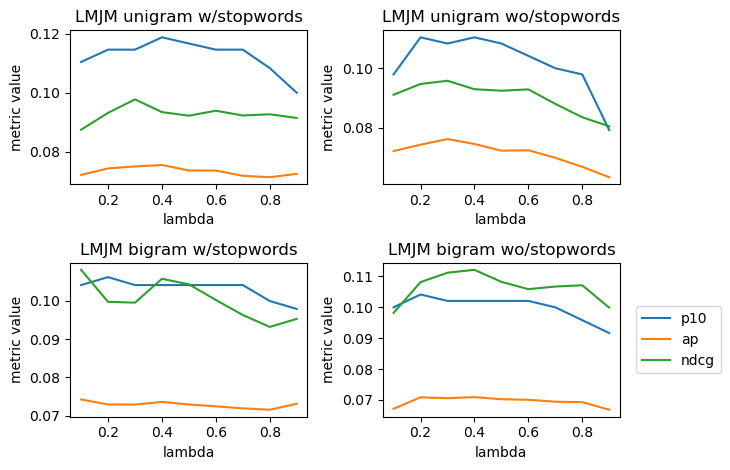

In [48]:
import matplotlib.pyplot as plt
#plt.plot(recall_11point,avg_precision_11point/len(cases))

metrics_all_lmjm=[metrics_lmjm,metrics_lmjm1,metrics_lmjm2,metrics_lmjm3]
metrics_all_lmjm=np.array(metrics_all_lmjm)
def show_plots(metrics):
    fig = plt.figure()
    titles=("LMJM unigram w/stopwords","LMJM unigram wo/stopwords","LMJM bigram w/stopwords","LMJM bigram wo/stopwords")
    for i in range(len(metrics)):
        plt.subplot(2, 2, i+1)
        plt.title(titles[i])
        plt.xlabel("lambda")
        plt.ylabel("metric value")
        plt.plot(np.arange(0.1,1,0.1),metrics[i,:][:,0],label="p10")
        plt.plot(np.arange(0.1,1,0.1),metrics[i,:][:,2],label="ap")
        plt.plot(np.arange(0.1,1,0.1),metrics[i,:][:,3],label="ndcg")
        plt.tight_layout()
    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
    plt.show()

show_plots(metrics_all_lmjm)

In [61]:
# evaluate model with best lambda on testset
#considering the results of models above. we've chosen LMJM Unigram considering stopwords and set a lambda=0.4  
metrics_test=[]
precision_11point_t, recall_11point_t, total_relv_ret_t=[],[],[]
p10_t, recall_t, ap_t, ndcg_t, mrr_t=0,0,0,0,0
for caseid in cases_test:
    # implementar LMJM unigram
    scores_LMJM= LMJM("unigram","english").search(caseid,brief_summaries,0.4)
    results_LMJM = pd.DataFrame(list(zip(ids, scores_LMJM[0])), columns = ['_id', 'score_lmj'])
    results_ord_LMJM = results_LMJM.sort_values(by=['score_lmj'], ascending = False)
    #all_scores_LMJM.append(sorted(list(zip(ids,scores_LMJM[0])),key=lambda x:x[1],reverse=True))
    p10, recall, ap, ndcg5, mrr = eval.eval(results_ord_LMJM, caseid)
    precision_11point, recall_11point, total_relv_ret = eval.evalPR(results_ord_LMJM, caseid)
    p10_t+=p10
    recall_t+=recall
    ap_t+= ap
    ndcg_t+=ndcg5
    mrr_t+=mrr
    precision_11point_t.append(precision_11point)
    if (np.shape(recall_11point) != (0,)):
        recall_11point_t.append(recall_11point)
metrics_test.append([p10_t/len(cases_test), recall_t/len(cases_test), ap_t/len(cases_test), ndcg_t/len(cases_test), mrr_t/len(cases_test)])
print(metrics_test)

[[0.11666666666666668, 1.0, 0.0555234492418346, 0.10467427779940569, 0.006182202610774039]]


In [57]:
# evaluate on testset the VSM model that perfomed better on training set (VSM Bigram w/stopwords)
metrics_test=[]
p10_t, recall_t, ap_t, ndcg_t, mrr_t=0,0,0,0,0
precision_11point_tv, recall_11point_tv, total_relv_ret_t=[],[],[]
for caseid in cases_test:
    # implementar
    scores= flatten_arr(VSM("bigram","english").search(caseid,brief_summaries))
    results_vsm = pd.DataFrame(list(zip(ids, scores)), columns = ['_id', 'score'])
    results_ord_vsm = results_vsm.sort_values(by=['score'], ascending = False)
    p10vsm, recallvsm, apvsm, ndcg5vsm, mrrvsm = eval.eval(results_ord_vsm, caseid)
    precision_11pointvsm, recall_11pointvsm, total_relv_retvsm = eval.evalPR(results_ord_vsm, caseid)   
    p10_t+=p10vsm
    recall_t+=recallvsm
    ap_t+= apvsm
    ndcg_t+=ndcg5vsm
    mrr_t+=mrrvsm
    precision_11point_tv.append(precision_11pointvsm)
    if (np.shape(recall_11point) != (0,)):
        recall_11point_tv.append(recall_11pointvsm)
metrics_test.append([p10_t/len(cases_test), recall_t/len(cases_test), ap_t/len(cases_test), ndcg_t/len(cases_test), mrr_t/len(cases_test)])
print(metrics_test)

[[0.09166666666666667, 1.0, 0.05012100253450214, 0.06435408289768361, 0.006182202610774039]]


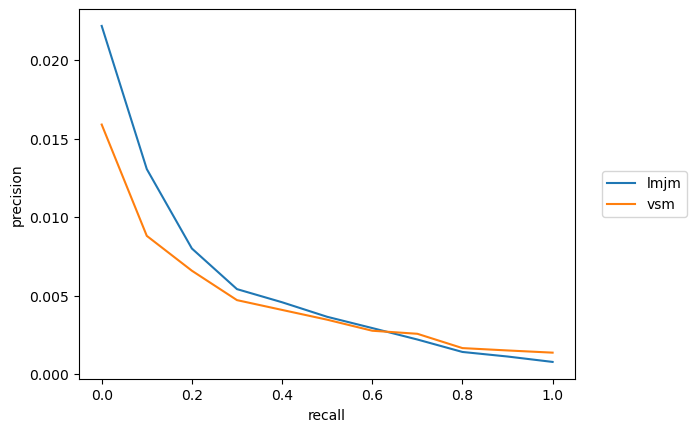

In [62]:
# curve vsm & lmjm
precision_11=np.array(precision_11point_t).mean(axis=0)
recall_11=np.array(recall_11point_t).mean(axis=0)
precision_11v=np.array(precision_11point_tv).mean(axis=0)
recall_11v=np.array(recall_11point_tv).mean(axis=0)

plt.figure()
plt.xlabel("recall")
plt.ylabel("precision")
plt.plot(recall_11,precision_11/len(cases_test),label="lmjm")
plt.plot(recall_11v,precision_11v/len(cases_test),label="vsm")
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
plt.show()